# total files 

plot_token_vs_extraction_trends.py

In [ ]:
import json
from pathlib import Path
import pandas as pd



In [19]:
def load_model_sections(model_dir: Path, law_name: str, model_name: str) -> pd.DataFrame:
    """
    Load section JSON files for one model & one law.
    model_name used to pick slm/llm/ollama prefix for extracted_* keys.
    Returns DataFrame sorted by token_count.
    """
    records = []
    prefix_map = {
        "SLM": "slm",
        "LLM": "llm",
        "Llama 3.1:8b": "ollama",
        "ollama": "ollama",
        "slm": "slm",
        "llm": "llm",
    }
    prefix = prefix_map.get(model_name, None)

    law_dir = model_dir / law_name
    if not law_dir.exists():
        print(f"⚠ directory not found: {law_dir}")
        return pd.DataFrame()

    for json_file in sorted(law_dir.glob("*.json")):
        try:
            with open(json_file, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            print(f"skip {json_file.name}: load error {e}")
            continue

        meta = data.get("meta")
        if not isinstance(meta, dict):
            print(f"skip {json_file.name}: missing or invalid meta")
            continue

        graph_stats = meta.get("graph_stats", {}) or {}

        # prefer model-specific keys, else any *_extracted_nodes/_relationships, else fallback to total_*
        def pick(key_suffix, fallback_total):
            # try model-specific prefix
            if prefix:
                k = f"{prefix}_{key_suffix}"
                if k in graph_stats:
                    return graph_stats.get(k, 0)
            # try any key that endswith _{key_suffix}
            for k in graph_stats:
                if k.endswith(f"_{key_suffix}"):
                    return graph_stats.get(k, 0)
            # fallback to provided total key in graph_stats or 0
            return graph_stats.get(fallback_total, 0)

        extracted_nodes = pick("extracted_nodes", "total_nodes")
        extracted_rels = pick("extracted_relationships", "total_relationships")
        total_nodes = graph_stats.get("total_nodes", 0)
        total_relationships = graph_stats.get("total_relationships", 0)

        # compute ratio: prefer model-extracted ratio if nodes>0, else use total ratio, else 0
        if extracted_nodes > 0:
            rel_node_ratio = extracted_rels / extracted_nodes
        elif total_nodes > 0:
            rel_node_ratio = total_relationships / total_nodes
        else:
            rel_node_ratio = 0.0

        records.append({
            "section_id": meta.get("record_id"),
            "token_count": meta.get("token_count", 0),
            "total_nodes": total_nodes,
            "total_relationships": total_relationships,
            "extracted_nodes": int(extracted_nodes),
            "extracted_relationships": int(extracted_rels),
            "rel_node_ratio": rel_node_ratio,
            "source_file": json_file.name,
        })

    if not records:
        return pd.DataFrame()

    df = pd.DataFrame(records)
    df = df.sort_values("token_count").reset_index(drop=True)
    return df



In [28]:
BASE_DIR = Path("../../neo4j_data/Legal_Discourse_Graph/")
BASE_DIR_TOP = Path("../../data_analysis/results/top_10/")
BASE_DIR_BOTTOM = Path("../../data_analysis/results/bottom_10/")

LAW_NAME = "act-1997-078"

model_dirs = {
    "SLM": BASE_DIR / "slm",
    "LLM": BASE_DIR / "llm",
    "Llama 3.1:8b": BASE_DIR / "ollama",
}

dfs = {
    model_name: load_model_sections(model_dir, LAW_NAME, model_name)
    for model_name, model_dir in model_dirs.items()
}

model_dirs_top = {
    "SLM": BASE_DIR_TOP / "slm",
    "LLM": BASE_DIR_TOP / "llm",
    "Llama 3.1:8b": BASE_DIR_TOP / "ollama",
}

dfs_top = {
    model_name: load_model_sections(model_dir, LAW_NAME, model_name)
    for model_name, model_dir in model_dirs_top.items()
}

model_dirs_bottom = {
    "SLM": BASE_DIR_BOTTOM / "slm",
    "LLM": BASE_DIR_BOTTOM / "llm",
    "Llama 3.1:8b": BASE_DIR_BOTTOM / "ollama",
}

dfs_bottom = {
    model_name: load_model_sections(model_dir, LAW_NAME, model_name)
    for model_name, model_dir in model_dirs_bottom.items()
}

In [4]:
# In a new cell
!pip install matplotlib

In [5]:
# Verify Python environment and install matplotlib
import sys
print(f"Python: {sys.executable}")
print(f"Version: {sys.version}")

try:
    import matplotlib
    print(f"✓ matplotlib {matplotlib.__version__} installed")
except ImportError:
    print("Installing matplotlib...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])

Python: /Users/yaz/Desktop/free_topic/.venv/bin/python
Version: 3.14.2 (v3.14.2:df793163d58, Dec  5 2025, 12:18:06) [Clang 16.0.0 (clang-1600.0.26.6)]
✓ matplotlib 3.10.8 installed


In [6]:
import matplotlib.pyplot as plt


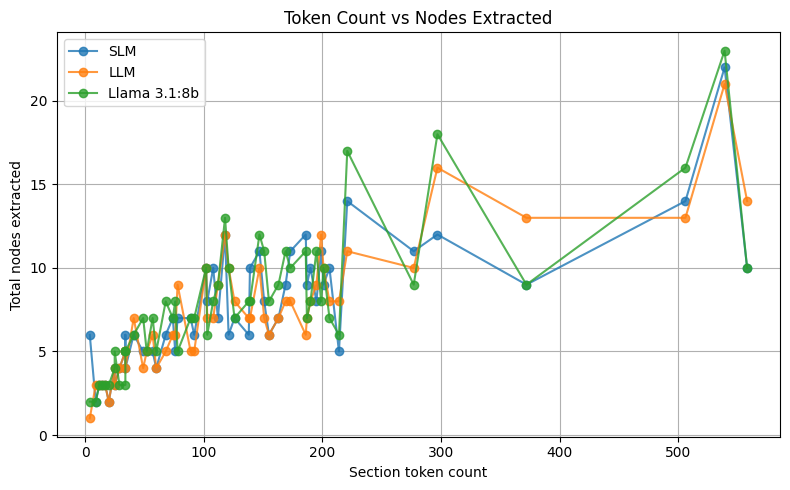

In [14]:
plt.figure(figsize=(8, 5))

for model_name, df in dfs.items():
    plt.plot(
        df["token_count"],
        df["total_nodes"],
        label=model_name,
        marker="o",
        alpha=0.8
    )

plt.xlabel("Section token count")
plt.ylabel("Total nodes extracted")
plt.title("Token Count vs Nodes Extracted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 30.3 MB/s  0:00:00eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/10.0 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 30.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 64.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 64.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [statsmodels] [statsmodels]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [statsmodels]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess


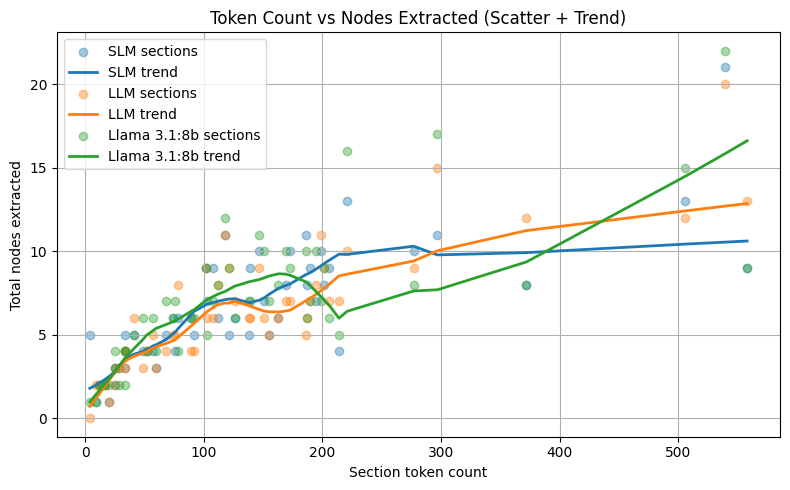

In [ ]:
plt.figure(figsize=(8, 5))

for model_name, df in dfs.items():
    x = df["token_count"].values
    y = df["extracted_nodes"].values

    # 1. Scatter plot for raw data points
    plt.scatter(
        x, y,
        alpha=0.4,
        label=f"{model_name} sections"
    )

    # 2. LOWESS smoothing line
    smoothed = lowess(y, x, frac=0.3)  # frac controls smoothing level
    plt.plot(
        smoothed[:, 0],
        smoothed[:, 1],
        linewidth=2,
        label=f"{model_name} trend"
    )

plt.xlabel("Section token count")
plt.ylabel("Total nodes extracted")
plt.title("Token Count vs Nodes Extracted (Scatter + Trend)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


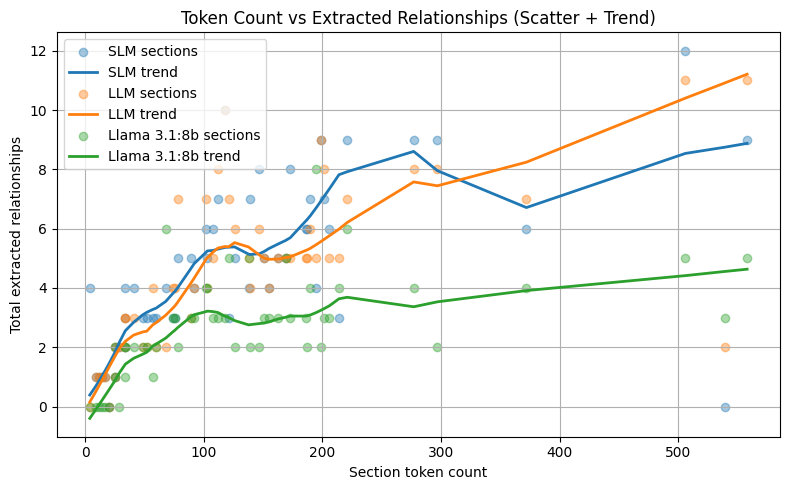

In [24]:
plt.figure(figsize=(8, 5))

for model_name, df in dfs.items():
    x = df["token_count"].values
    y = df["extracted_relationships"].values

    # 1. Scatter plot for raw data points
    plt.scatter(
        x, y,
        alpha=0.4,
        label=f"{model_name} sections"
    )

    # 2. LOWESS smoothing line
    smoothed = lowess(y, x, frac=0.3)  # frac controls smoothing level
    plt.plot(
        smoothed[:, 0],
        smoothed[:, 1],
        linewidth=2,
        label=f"{model_name} trend"
    )

plt.xlabel("Section token count")
plt.ylabel("Total extracted relationships")
plt.title("Token Count vs Extracted Relationships (Scatter + Trend)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


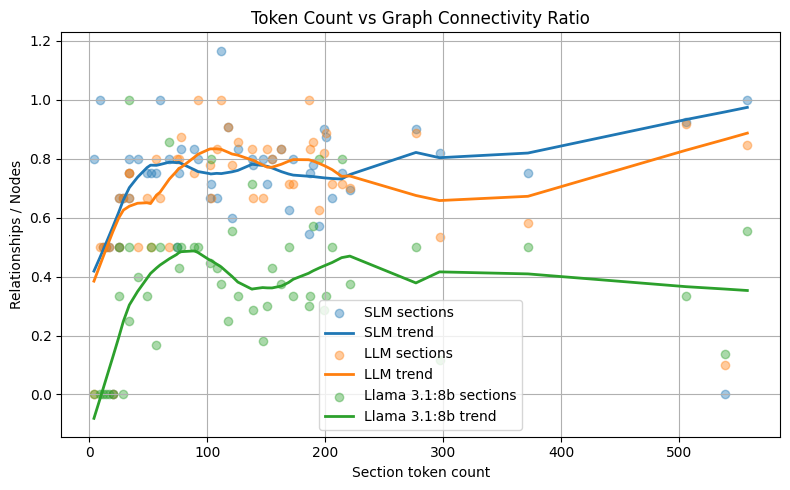

In [25]:
plt.figure(figsize=(8, 5))

for model_name, df in dfs.items():
    x = df["token_count"].values
    y = df["rel_node_ratio"].values

    plt.scatter(x, y, alpha=0.4, label=f"{model_name} sections")

    smoothed = lowess(y, x, frac=0.3)
    plt.plot(smoothed[:, 0], smoothed[:, 1], linewidth=2, label=f"{model_name} trend")

plt.xlabel("Section token count")
plt.ylabel("Relationships / Nodes")
plt.title("Token Count vs Graph Connectivity Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# token top 10% and bottom 10% result

## top 10

In [ ]:
def load_model_sections(model_dir: Path, law_name: str, model_name: str) -> pd.DataFrame:
    """
    Load section JSON files for one model & one law.
    model_name used to pick slm/llm/ollama prefix for extracted_* keys.
    Returns DataFrame sorted by token_count.
    """
    records = []
    prefix_map = {
        "SLM": "slm",
        "LLM": "llm",
        "Llama 3.1:8b": "ollama",
        "ollama": "ollama",
        "slm": "slm",
        "llm": "llm",
    }
    prefix = prefix_map.get(model_name, None)

    law_dir = model_dir / law_name
    if not law_dir.exists():
        print(f"⚠ directory not found: {law_dir}")
        return pd.DataFrame()

    for json_file in sorted(law_dir.glob("*.json")):
        try:
            with open(json_file, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            print(f"skip {json_file.name}: load error {e}")
            continue

        meta = data.get("meta")
        if not isinstance(meta, dict):
            print(f"skip {json_file.name}: missing or invalid meta")
            continue

        graph_stats = meta.get("graph_stats", {}) or {}

        # prefer model-specific keys, else any *_extracted_nodes/_relationships, else fallback to total_*
        def pick(key_suffix, fallback_total):
            # try model-specific prefix
            if prefix:
                k = f"{prefix}_{key_suffix}"
                if k in graph_stats:
                    return graph_stats.get(k, 0)
            # try any key that endswith _{key_suffix}
            for k in graph_stats:
                if k.endswith(f"_{key_suffix}"):
                    return graph_stats.get(k, 0)
            # fallback to provided total key in graph_stats or 0
            return graph_stats.get(fallback_total, 0)

        extracted_nodes = pick("extracted_nodes", "total_nodes")
        extracted_rels = pick("extracted_relationships", "total_relationships")
        total_nodes = graph_stats.get("total_nodes", 0)
        total_relationships = graph_stats.get("total_relationships", 0)

        # compute ratio: prefer model-extracted ratio if nodes>0, else use total ratio, else 0
        if extracted_nodes > 0:
            rel_node_ratio = extracted_rels / extracted_nodes
        elif total_nodes > 0:
            rel_node_ratio = total_relationships / total_nodes
        else:
            rel_node_ratio = 0.0

        records.append({
            "section_id": meta.get("record_id"),
            "token_count": meta.get("token_count", 0),
            "total_nodes": total_nodes,
            "total_relationships": total_relationships,
            "extracted_nodes": int(extracted_nodes),
            "extracted_relationships": int(extracted_rels),
            "rel_node_ratio": rel_node_ratio,
            "source_file": json_file.name,
        })

    if not records:
        return pd.DataFrame()

    df = pd.DataFrame(records)
    df = df.sort_values("token_count").reset_index(drop=True)
    return df

# Replace building dfs/dfs_top to pass model_name:
BASE_DIR = Path("../../neo4j_data/Legal_Discourse_Graph/")
BASE_DIR_TOP = Path("../../data_analysis/results/top_10/")
LAW_NAME = "act-1997-078"

model_dirs = {
    "SLM": BASE_DIR / "slm",
    "LLM": BASE_DIR / "llm",
    "Llama 3.1:8b": BASE_DIR / "ollama",
}

dfs = {
    model_name: load_model_sections(model_dir, LAW_NAME, model_name)
    for model_name, model_dir in model_dirs.items()
}

model_dirs_top = {
    "SLM": BASE_DIR_TOP / "slm",
    "LLM": BASE_DIR_TOP / "llm",
    "Llama 3.1:8b": BASE_DIR_TOP / "ollama",
}

dfs_top = {
    model_name: load_model_sections(model_dir, LAW_NAME, model_name)
    for model_name, model_dir in model_dirs_top.items()
}



In [ ]:
BASE_DIR_TOP = Path("../../data_analysis/results/top_10/")
BASE_DIR_BOTTOM = Path("../../data_analysis/results/bottom_10/")
LAW_NAME = "act-1997-078"

model_dirs_top = {
    "SLM": BASE_DIR_TOP / "slm",
    "LLM": BASE_DIR_TOP / "llm",
    "Llama 3.1:8b": BASE_DIR_TOP / "ollama",
}

dfs_top = {
    model_name: load_model_sections(model_dir, LAW_NAME)
    for model_name, model_dir in model_dirs_top.items()
}


}

TypeError: load_model_sections() missing 1 required positional argument: 'model_name'

In [ ]:
# Calculate average extracted nodes and relationships for top 10% files

for model_name, df in dfs.items():
    if df.empty:
        print(f"\n{model_name}: No data")
        continue
    
    avg_nodes = df["extracted_nodes"].mean()
    avg_rels = df["extracted_relationships"].mean()
    avg_ratio = df["rel_node_ratio"].mean()
    
    print(f"\n{model_name} (Top 10% files, n={len(df)}):")
    print(f"  Average extracted nodes: {avg_nodes:.2f}")
    print(f"  Average extracted relationships: {avg_rels:.2f}")
    print(f"  Average rel/node ratio: {avg_ratio:.2f}")

# Optional: Compare with all files
print("\n" + "="*50)
print("Comparison with ALL files:")
print("="*50)

for model_name, df in dfs.items():
    if df.empty:
        continue
    
    avg_nodes = df["extracted_nodes"].mean()
    avg_rels = df["extracted_relationships"].mean()
    avg_ratio = df["rel_node_ratio"].mean()
    
    print(f"\n{model_name} (All files, n={len(df)}):")
    print(f"  Average extracted nodes: {avg_nodes:.2f}")
    print(f"  Average extracted relationships: {avg_rels:.2f}")
    print(f"  Average rel/node ratio: {avg_ratio:.2f}")

In [30]:
# Calculate average extracted nodes and relationships for top 10% files

for model_name, df in dfs_top.items():
    if df.empty:
        print(f"\n{model_name}: No data")
        continue
    
    avg_nodes = df["extracted_nodes"].mean()
    avg_rels = df["extracted_relationships"].mean()
    avg_ratio = df["rel_node_ratio"].mean()
    
    print(f"\n{model_name} (Top 10% files, n={len(df)}):")
    print(f"  Average extracted nodes: {avg_nodes:.2f}")
    print(f"  Average extracted relationships: {avg_rels:.2f}")
    print(f"  Average rel/node ratio: {avg_ratio:.2f}")

# Optional: Compare with all files
print("\n" + "="*50)
print("Comparison with BOTTOM files:")
print("="*50)

for model_name, df in dfs_bottom.items():
    if df.empty:
        continue

    avg_nodes = df["extracted_nodes"].mean()
    avg_rels = df["extracted_relationships"].mean()
    avg_ratio = df["rel_node_ratio"].mean()

    print(f"\n{model_name} (Bottom 10% files, n={len(df)}):")
    print(f"  Average extracted nodes: {avg_nodes:.2f}")
    print(f"  Average extracted relationships: {avg_rels:.2f}")
    print(f"  Average rel/node ratio: {avg_ratio:.2f}")

print("\n" + "="*50)
print("Comparison with ALL files:")
print("="*50)

for model_name, df in dfs.items():
    if df.empty:
        continue
    
    avg_nodes = df["extracted_nodes"].mean()
    avg_rels = df["extracted_relationships"].mean()
    avg_ratio = df["rel_node_ratio"].mean()
    
    print(f"\n{model_name} (All files, n={len(df)}):")
    print(f"  Average extracted nodes: {avg_nodes:.2f}")
    print(f"  Average extracted relationships: {avg_rels:.2f}")
    print(f"  Average rel/node ratio: {avg_ratio:.2f}")


SLM (Top 10% files, n=10):
  Average extracted nodes: 10.60
  Average extracted relationships: 7.00
  Average rel/node ratio: 0.74

LLM (Top 10% files, n=10):
  Average extracted nodes: 11.40
  Average extracted relationships: 7.20
  Average rel/node ratio: 0.69

Llama 3.1:8b (Top 10% files, n=10):
  Average extracted nodes: 11.50
  Average extracted relationships: 3.90
  Average rel/node ratio: 0.42

Comparison with BOTTOM files:

SLM (Bottom 10% files, n=10):
  Average extracted nodes: 2.40
  Average extracted relationships: 1.50
  Average rel/node ratio: 0.58

LLM (Bottom 10% files, n=10):
  Average extracted nodes: 2.00
  Average extracted relationships: 1.10
  Average rel/node ratio: 0.45

Llama 3.1:8b (Bottom 10% files, n=10):
  Average extracted nodes: 2.30
  Average extracted relationships: 0.50
  Average rel/node ratio: 0.13

Comparison with ALL files:

SLM (All files, n=53):
  Average extracted nodes: 6.58
  Average extracted relationships: 4.75
  Average rel/node ratio: 0.7

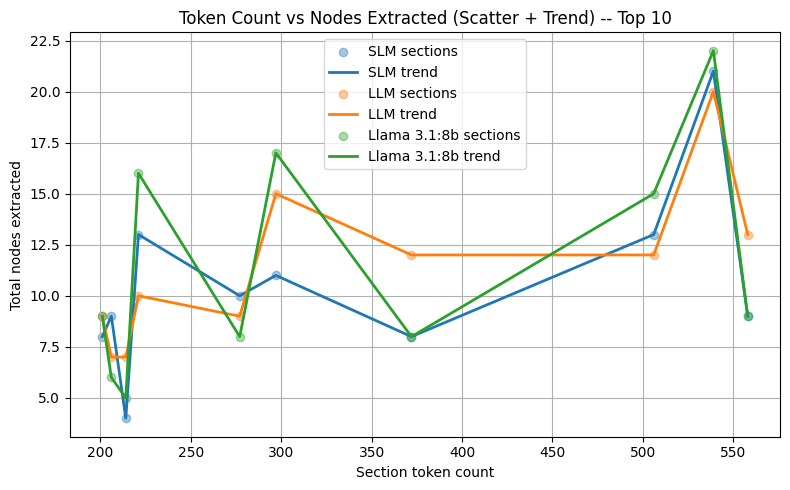

In [15]:
plt.figure(figsize=(8, 5))

for model_name, df in dfs_top.items():
    if df.empty:
        continue

    x = df.get("token_count", pd.Series(dtype=float)).values
    if x.size == 0:
        continue

    # Use extracted_nodes column (already populated by load_model_sections with model_name parameter)
    if "extracted_nodes" in df.columns:
        y = df["extracted_nodes"].values
    else:
        # fallback to total_nodes if present, else zeros
        if "total_nodes" in df.columns:
            y = df["total_nodes"].values
        else:
            y = np.zeros_like(x, dtype=float)

    # ensure numeric and no NaNs
    y = np.asarray(y, dtype=float)
    y = np.nan_to_num(y, nan=0.0)

    # 1. Scatter plot
    plt.scatter(x, y, alpha=0.4, label=f"{model_name} sections")

    # 2. LOWESS smoothing: only when enough points and some variance
    try:
        if x.size >= 3 and not np.allclose(y, y[0]):
            smoothed = lowess(y, x, frac=0.3)
            plt.plot(smoothed[:, 0], smoothed[:, 1], linewidth=2, label=f"{model_name} trend")
    except Exception:
        pass

plt.xlabel("Section token count")
plt.ylabel("Total nodes extracted")
plt.title("Token Count vs Nodes Extracted (Scatter + Trend) -- Top 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

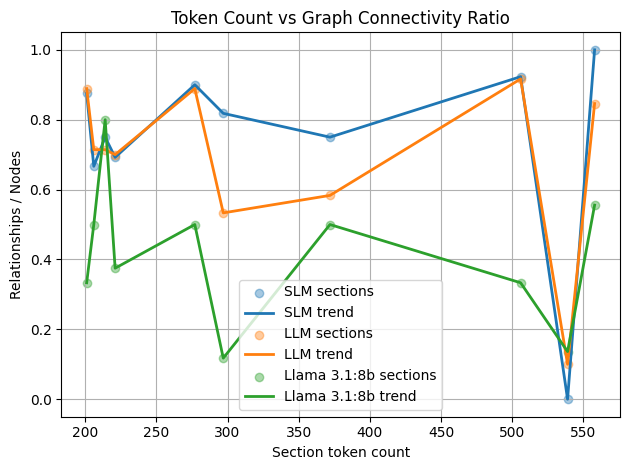

In [17]:


for model_name, df in dfs_top.items():
    if df.empty:
        continue

    x = df.get("token_count", pd.Series(dtype=float)).values
    if x.size == 0:
        continue

    # Use extracted_nodes column (already populated by load_model_sections with model_name parameter)
    if "rel_node_ratio" in df.columns:
        y = df["rel_node_ratio"].values
    else:
        # fallback to total_nodes if present, else zeros
        if "rel_node_ratio" in df.columns:
            y = df["rel_node_ratio"].values
        else:
            y = np.zeros_like(x, dtype=float)

    # ensure numeric and no NaNs
    y = np.asarray(y, dtype=float)
    y = np.nan_to_num(y, nan=0.0)

    # 1. Scatter plot
    plt.scatter(x, y, alpha=0.4, label=f"{model_name} sections")

    # 2. LOWESS smoothing: only when enough points and some variance
    try:
        if x.size >= 3 and not np.allclose(y, y[0]):
            smoothed = lowess(y, x, frac=0.3)
            plt.plot(smoothed[:, 0], smoothed[:, 1], linewidth=2, label=f"{model_name} trend")
    except Exception:
        pass

plt.xlabel("Section token count")
plt.ylabel("Relationships / Nodes")
plt.title("Token Count vs Graph Connectivity Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()